In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## Model parameters

In [2]:
# Taken "as is" from the Kaggle notebook
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
import gc; gc.enable() # memory is tight

## Read data

In [ ]:
FOLDER_RAW_ORIG = '../data/raw/pipistrel/2018-10-07_Bodensee_chronologisch/'
FOLDER_SCALED = '../data/processed/pipistrel/scaled-256-square/'
IMAGES_PATH = Path(FOLDER_SCALED)

In [36]:
import cv2
import pandas as pd
from tqdm import tqdm
import numpy as np
from pathlib import Path

# Utility functions
def display_image(image_name=None, parent="../data/processed/pipistrel/scaled-200/"):
    image = (Path(parent) / image_name).as_posix()
    plt.imshow(cv2.imread(image))

def get_image_shape(image_name=None, parent="../data/processed/pipistrel/scaled-200/"):
    image = (Path(parent) / image_name).as_posix()
    return cv2.imread(image).shape

def get_image_from_name(image_name=None, parent="../data/processed/pipistrel/scaled-200/"):
    image = (Path(parent) / image_name).as_posix()
    return cv2.imread(image)

def update_mask(mask, bbox_data):
    x1, y1, x2, y2 = bbox_data
    # Remember the image axis are inverted!!! (Y, X)
    mask[y1:y2, x1:x2] = 1
    return mask

import random

def get_scaling(orig_folder, dest_folder):
    image = random.sample([x for x in Path(orig_folder).glob('*.jpg')], 1)[0]
    shape = cv2.imread(image.as_posix()).shape
#     print(shape)
    size_x_orig = shape[1]
    size_y_orig = shape[0]
    image = random.sample([x for x in Path(dest_folder).glob('*.jpg')], 1)[0]
    shape = cv2.imread(image.as_posix()).shape
#     print(shape)
    size_x = shape[1]
    size_y = shape[0]
#     img_orig = get_image_from_name()
    return size_x / size_x_orig * 100, size_y / size_y_orig * 100

SCALE_PERCENT_X, SCALE_PERCENT = get_scaling(FOLDER_RAW_ORIG, FOLDER_SCALED)

In [39]:
def get_df_training_masks(df, scale_percent=5, scale_percent_x=None, images_path=None):
    """See 06-mg-bounding-boxes.ipynb notebook"""
    if scale_percent_x is None:
        scale_percent_x = scale_percent
    df['boat'] = (df['class'] == 'boat').astype(np.int64)
    df.drop(columns=['class', 'trackid'], inplace=True)
    # Get number of boats per image
    df_nboats = df.groupby('filename')['boat'].sum()
    df_nboats = df_nboats.rename('n_boats')
    # Add number of boats col
    df = df.join(df_nboats, on='filename')
    # Separate boat and no-boat
    df_no_boat = df[df['n_boats']==0]
    # Keep one record per image
    df_no_boat = df_no_boat.groupby('filename', as_index=False)['n_boats'].first()
    # Now boat images
    # Some records have "nature" bboxes that we don't want (boat==0 & n_boat==1)
    df_boat = df[(df['n_boats'] > 0) & (df['boat'] > 0)]
    # Rescale bboxes according to the given scale percentage
#     df_boat.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] = (
#         df_boat.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] * scale_percent / 100
#     ).round(0).astype(np.int64)
    df_boat.loc[:, ['xmin', 'xmax']] = (
        df_boat.loc[:, ['xmin', 'xmax']] * scale_percent_x / 100
    ).round(0).astype(np.int64)
    df_boat.loc[:, ['ymin', 'ymax']] = (
        df_boat.loc[:, ['ymin', 'ymax']] * scale_percent / 100
    ).round(0).astype(np.int64)
    # Get one sample image
    pip_images_path = images_path
    image = [x for x in pip_images_path.glob('*.jpg')][0]
    # Create masks for boats
    size=get_image_shape(image.name, parent=images_path.as_posix())[:2]
    print(f'Image size: {size}')
    mask = {}
    for name, grp in tqdm(df_boat.groupby('filename')):
    #     print(i, grp)
        mask_tmp = np.zeros(size)
    #     print(mask_tmp.shape)
        for row in grp.itertuples():
    #         print(row)
            bbox_data = (row.xmin, row.ymin, row.xmax, row.ymax)
    #         print(bbox_data)
            mask_tmp = update_mask(mask_tmp, bbox_data)
        mask[name] = mask_tmp
    # Put mask in Series
    s_mask = pd.Series(mask, name='mask')
    # Create DF with masks
    df_boat = df_boat[['filename', 'n_boats']].groupby(
        'filename',
        as_index=False
    ).first().join(
        s_mask,
        on='filename',
        how='left'
    )
    # Add empty masks to no-boat images
    df_no_boat['mask'] = df_no_boat.apply(lambda x: np.zeros(size), axis=1)
    return pd.concat((df_boat, df_no_boat))

df = pd.read_csv('../data/raw/pipistrel/labelsTrain.csv')
df_data = get_df_training_masks(
    df,
    scale_percent=SCALE_PERCENT,
    scale_percent_x=SCALE_PERCENT_X,
    images_path=IMAGES_PATH,
)

/home/guzzo/anaconda3/envs/deepberlin/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
 30%|███       | 142/472 [00:00<00:00, 1418.80it/s]

Image size: (256, 256)


100%|██████████| 472/472 [00:00<00:00, 1563.73it/s]


In [40]:
df_data.head()

,filename,n_boats,mask
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-06.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-07.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-09.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-10.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [41]:
df_data.describe()

,n_boats
count,821.000000
mean,1.220463
std,1.495153
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,11.000000


### Train-test split

Shuffle data

In [42]:
df_data = df_data.sample(frac=1).reset_index(drop=True)

In [43]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_data, 
                 test_size = 0.2, 
                 stratify = df_data['n_boats']>0)
# train_df = pd.merge(masks, train_ids)
# valid_df = pd.merge(masks, valid_ids)
# print(df_train.shape[0], 'training masks')
# print(valid_df.shape[0], 'validation masks')
print(df_train.shape)
print(df_test.shape)

(656, 3)
(165, 3)


In [44]:
pd.concat((df_train.describe(), df_test.describe()), axis=1)

,n_boats,n_boats
count,656.000000,165.000000
mean,1.239329,1.145455
std,1.517041,1.406668
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,11.000000,10.000000


## Generate batches

In [45]:
def make_batches(in_df, batch_size=BATCH_SIZE, parent_folder=FOLDER_SCALED):
#     all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        for name, mask in in_df.groupby('filename')['mask']:
            image = get_image_from_name(name, parent=parent_folder)
            out_rgb += [image]
            # Need to add a dimension to the mask because of model requirements
            out_mask += [np.expand_dims(mask.values[0], -1)]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []

### Training set

In [46]:
train_gen = make_batches(df_train, parent_folder=FOLDER_SCALED)

In [47]:
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 256, 256, 3) 0.28627450980392155 0.8509803921568627
y (4, 256, 256, 1) 0.0 1.0


In [48]:
train_x.shape

(4, 256, 256, 3)

In [49]:
train_y.shape

(4, 256, 256, 1)

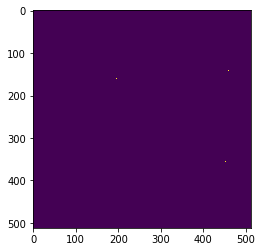

In [50]:
from skimage.util import montage
plt.imshow(montage(train_y[..., 0]))

Text(0.5, 1.0, 'Outlined Ships')

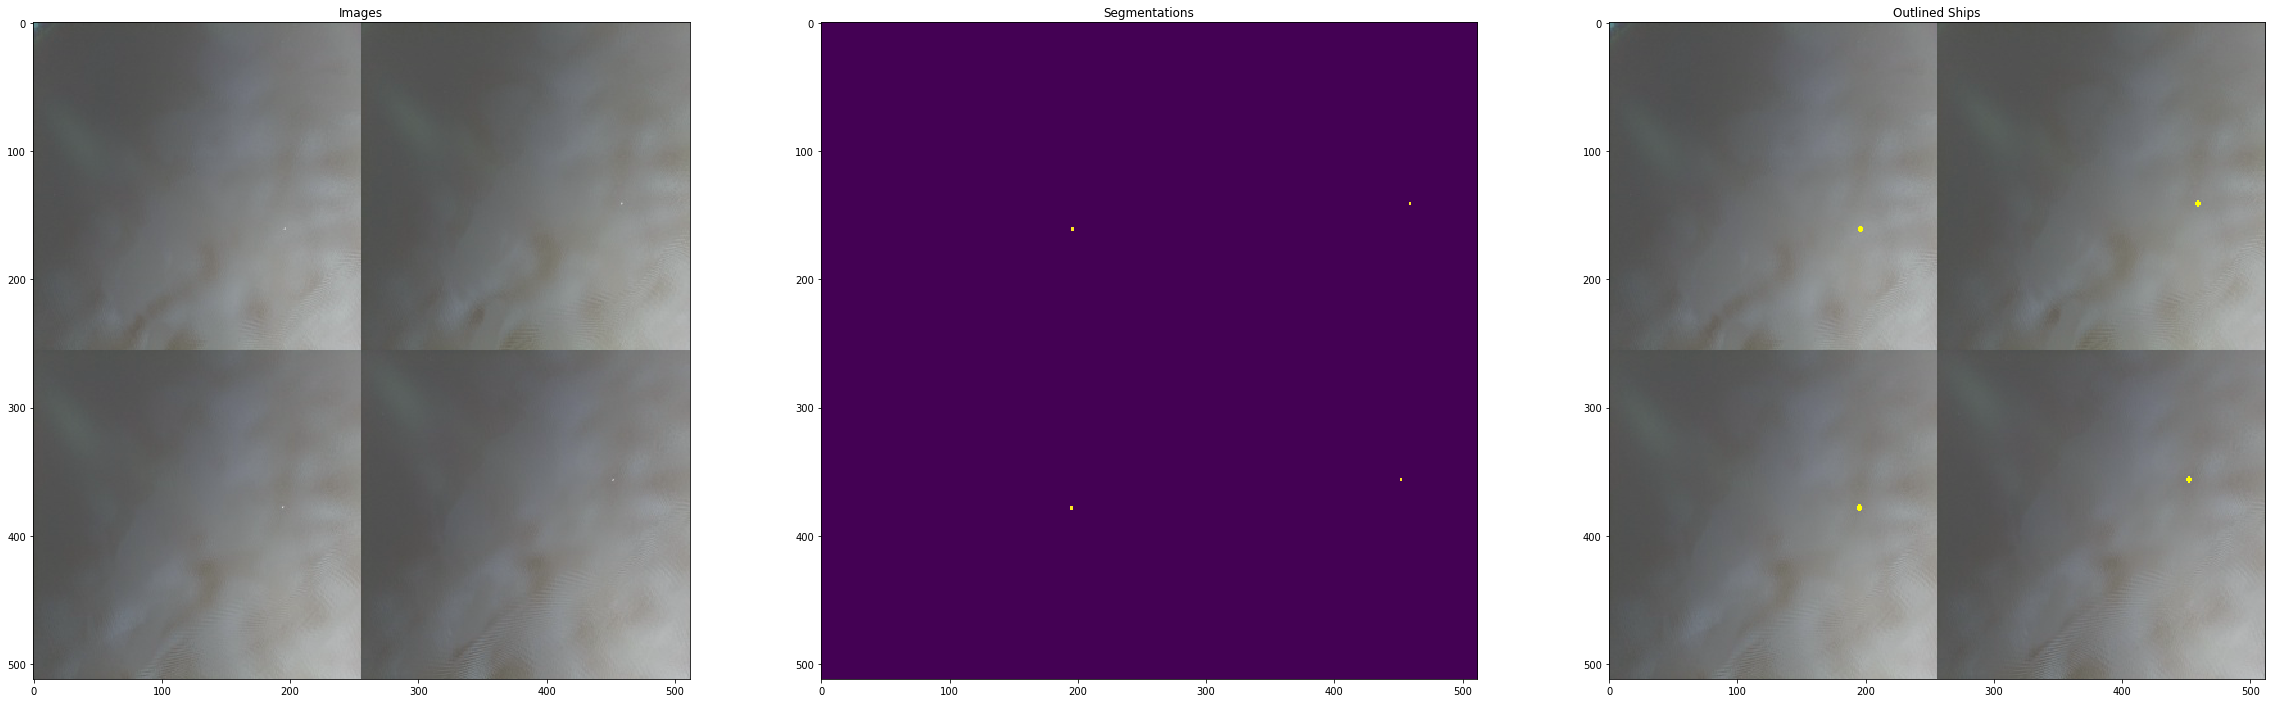

In [51]:
# Not sure what this is... probably just a check
from skimage.segmentation import mark_boundaries
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (40, 20))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')

### Test set

In [52]:
test_x, test_y = next(make_batches(df_test, VALID_IMG_COUNT))
print(test_x.shape, test_y.shape)

(400, 256, 256, 3) (400, 256, 256, 1)


## Augment data

In [53]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(
    featurewise_center = False, 
    samplewise_center = False,
    rotation_range = 15, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    shear_range = 0.01,
    zoom_range = [0.9, 1.25],  
    horizontal_flip = True, 
    vertical_flip = True,
    fill_mode = 'reflect',
    data_format = 'channels_last',
)
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (4, 256, 256, 3) float32 0.29625264 0.80656105
y (4, 256, 256, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

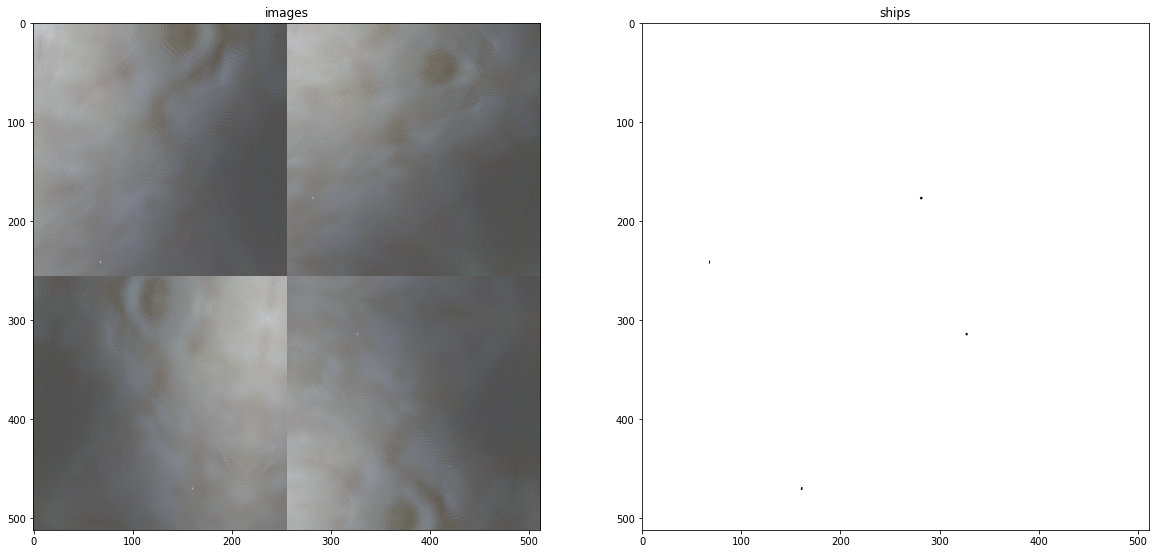

In [54]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [55]:
gc.collect()

149

In [56]:
t_y.shape

(4, 256, 256, 1)

In [57]:
t_y[0, :, :, 0].shape

(256, 256)

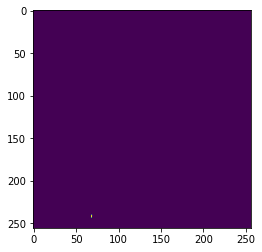

In [58]:
plt.imshow(t_y[0, :, :, 0])

(array([6.5532e+04, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.09531464, 0.19062927, 0.28594393, 0.38125855,
        0.4765732 , 0.57188785, 0.6672025 , 0.7625171 , 0.8578318 ,
        0.9531464 ], dtype=float32),
 <a list of 10 Patch objects>)

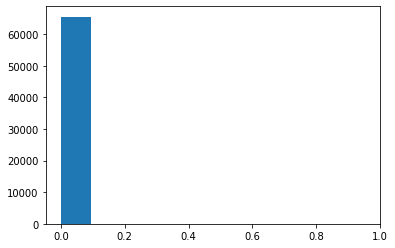

In [59]:
plt.hist(t_y[0, :, :, 0].flatten())

## Build a Model
Here we use a slight deviation on the U-Net standard

In [60]:
t_x.shape[1:]

(256, 256, 3)

In [61]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
print(c4.shape)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
print(u6.shape)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

(?, 32, 32, 64)
(?, 32, 32, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 3)  12          gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 8)  224         batch_normalization_2[0][0]      
____________________________________________________________________________

In [62]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(
    optimizer=Adam(1e-4, decay=1e-6),
    loss=dice_p_bce,
    metrics=[dice_coef, 'binary_accuracy', true_positive_rate],
)

W0728 13:12:07.945250 139966551369536 deprecation_wrapper.py:119] From /home/guzzo/anaconda3/envs/deepberlin/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 13:12:07.952225 139966551369536 deprecation.py:323] From /home/guzzo/anaconda3/envs/deepberlin/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [63]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


/home/guzzo/anaconda3/envs/deepberlin/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [66]:
step_count = min(MAX_TRAIN_STEPS, df_train.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_batches(df_train))
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(test_x, test_y),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/5
164/164 [==============================] - 136s 828ms/step - loss: -0.3903 - dice_coef: 0.3905 - binary_accuracy: 0.9841 - true_positive_rate: nan - val_loss: -0.4036 - val_dice_coef: 0.4036 - val_binary_accuracy: 0.9997 - val_true_positive_rate: nan

Epoch 00001: val_dice_coef improved from -inf to 0.40357, saving model to seg_model_weights.best.hdf5
Epoch 2/5
164/164 [==============================] - 127s 774ms/step - loss: -0.4748 - dice_coef: 0.4748 - binary_accuracy: 0.9994 - true_positive_rate: nan - val_loss: -0.4036 - val_dice_coef: 0.4036 - val_binary_accuracy: 0.9997 - val_true_positive_rate: nan

Epoch 00002: val_dice_coef improved from 0.40357 to 0.40359, saving model to seg_model_weights.best.hdf5
Epoch 3/5
164/164 [==============================] - 122s 742ms/step - loss: -0.4789 - dice_coef: 0.4789 - binary_accuracy: 0.9994 - true_positive_rate: nan - val_loss: -0.4036 - val_dice_coef: 0.4036 - val_binary_accuracy: 0.9997 - val_true_positive_rate: nan

Epoch 0

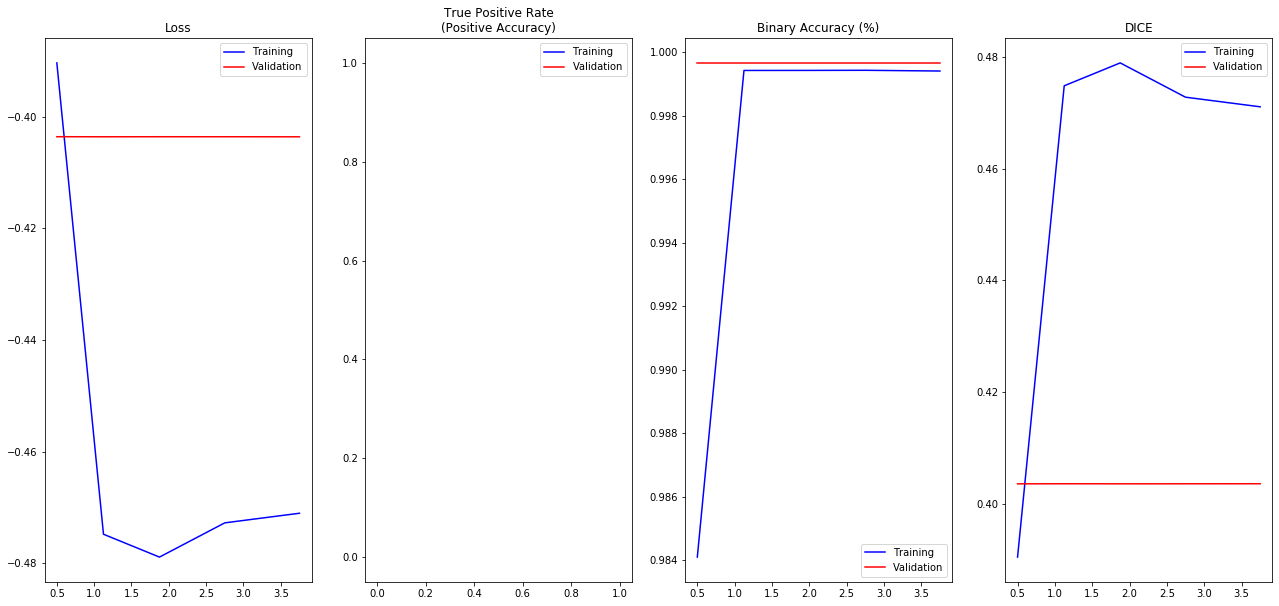

In [67]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [68]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [70]:
y_pred = seg_model.predict(test_x)
print(y_pred.shape, y_pred.min(), y_pred.max(), y_pred.mean())

(400, 256, 256, 1) 0.0 0.0029861033 3.027839e-07


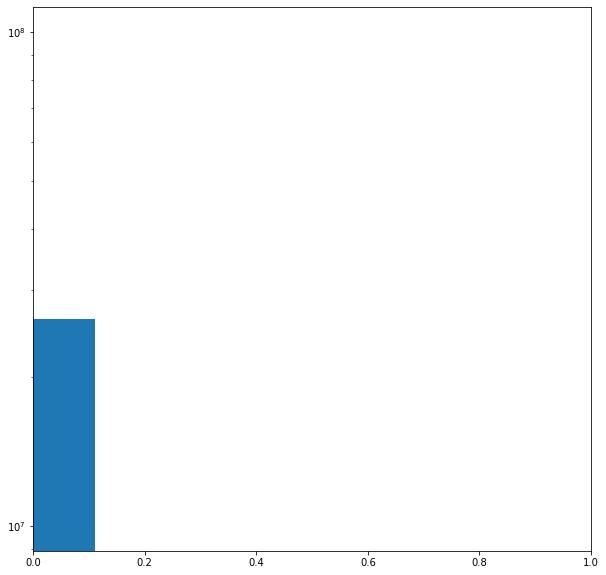

In [72]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(y_pred.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')